In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from careamics import Configuration, CAREamist
import re

sys.path.append(str(Path("..").resolve()))
from src import *

Cupy Available= 1


# Noise2Void Training
Let's try out some pupolar SOTA denoisers. In this experiment I will rely of [*CAREamics*](https://careamics.github.io) implementation, that is built with *PyThorch*, in contrast to the original [*Noise2Noise*](https://github.com/NVlabs/noise2noise), which uses *TensorFlow*.

## Training

In [ ]:
WORK_DIR=Path("n2v")
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, gt = (Recording(_, max_frames=60) for _ in [x_path, gt_path])

In [ ]:
config_dict = {
    "experiment_name": "N2V_synthetic",
    "algorithm_config": {
        "algorithm": "n2v",
        "loss": "n2v",
        "model": {
            "architecture": "UNet",
            # "num_channels":[64, 128, 256],
        },
    },
    "training_config": {
        "batch_size": 16,
        "num_epochs":10,
        # "learning_rate": 0.0004,
    },
    "data_config": {
        "data_type": "array",
        "axes": "ZYX",
        "patch_size": [32,128, 128],  # Noise2Void doesnt exploit temporal dim
    },
}
cfg = Configuration(**config_dict)

In [ ]:
engine = CAREamist(cfg, work_dir=WORK_DIR)
cprint("cyan:Starting N2V training...")
history = engine.train(train_source=x.np)

In [ ]:
# engine = CAREamist("checkpoints/N2V_synthetic-v5.ckpt")
y=engine.predict(x.np[:32,:244,:244])
y=y[0].squeeze().squeeze()

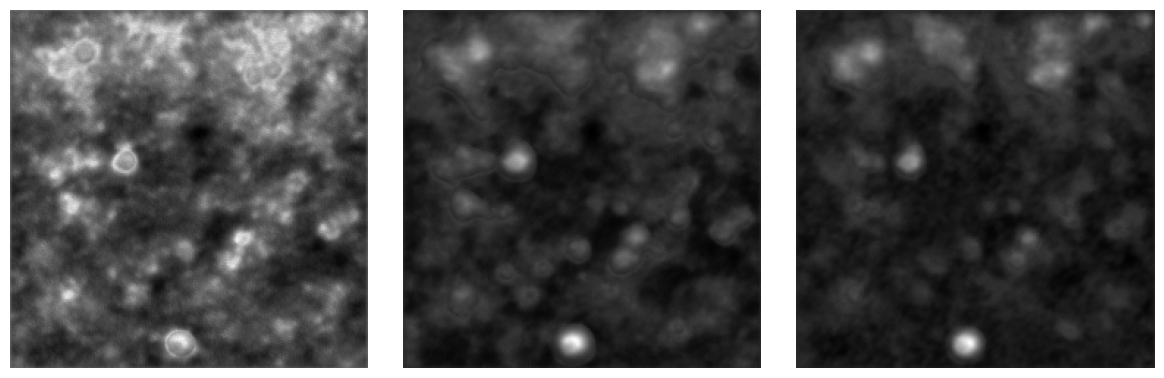

In [28]:
imshow([y[i] for i in [0,15,-1]])

In [ ]:
Recording(y[:60]).render("n2v.mp4", codec="libx264")

## Metric plotting

In [6]:
experiment="n2v_synthetic_frames6000_t32_ep10"

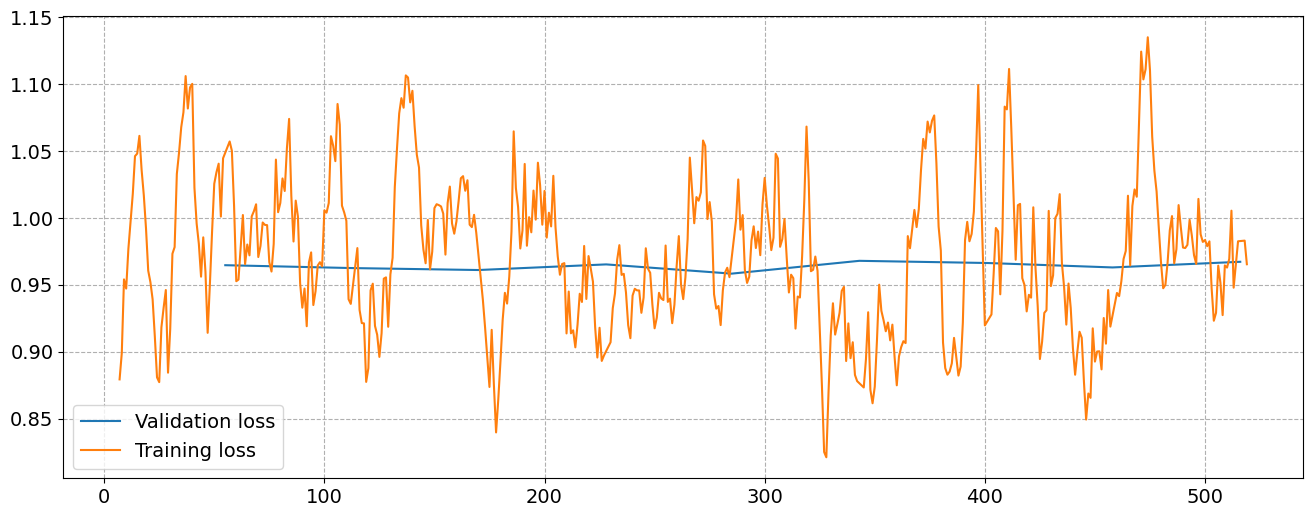

In [ ]:
df = pd.read_csv(f"n2v/csv_logs/{experiment}/version_0/metrics.csv")
ax = df["val_loss"].dropna().plot(figsize=(16, 6), label="Validation loss")
df["train_loss_step"].dropna().rolling(window=8).mean().plot(label="Training loss", ax=ax)
ax.legend()

## Grid search results

In [52]:
df = pd.read_csv("n2v_results/metrics.csv", index_col="suffx")
df_600 = df[df.index.str.contains("600")]
df_3000 = df[df.index.str.contains("3000")]
t_ext = lambda s: int(re.search(r"\_t(\d+)\_", s).group(1))

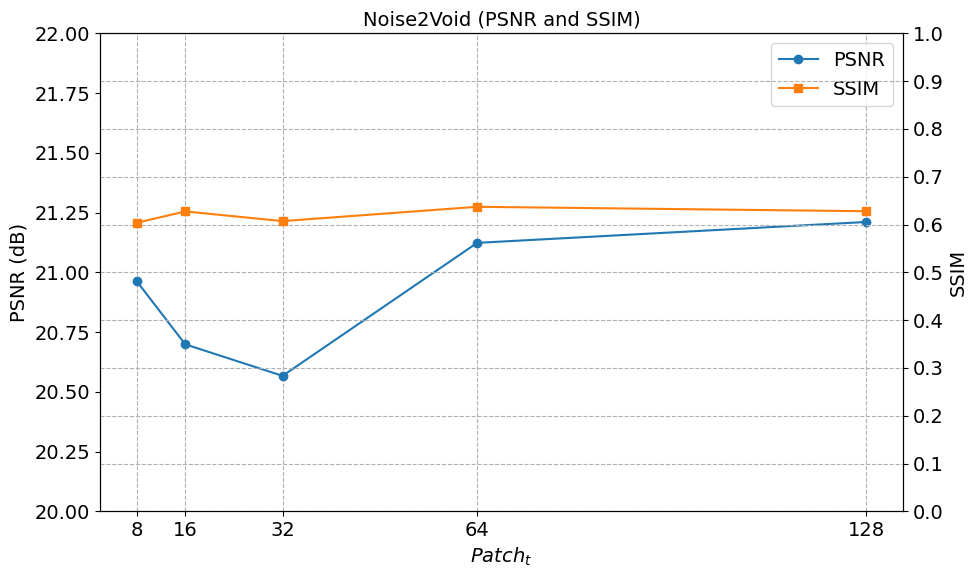

In [58]:
df=df_600
df["t"] = df.index.map(t_ext)
df = df.sort_values("t")
fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:blue"
ax1.set_xlabel("$Patch_t$")
ax1.set_ylabel("PSNR (dB)")
ax1.plot(df["t"], df["PSNR"], color=color, marker="o", label="PSNR")
ax1.set_ylim(20,22)
ax1.grid(False, axis="y")
ax1.set_xticks(df.t)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.set_ylabel("SSIM")
ax2.plot(df["t"], df["SSIM"], color=color, marker="s", label="SSIM")
ax2.set_ylim(0,1)
ax2.set_yticks([0.1*i for i in range(11)])
ax2.grid(True)

plt.title("Noise2Void (PSNR and SSIM)")
fig.tight_layout()
plt.grid(True)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2)
plt.show()
